In [1]:
import os
import csv
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
from scipy.stats import sem, t
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
BRCA1_function_data = "BRCA1_dbNSFP_function_data.csv"
BRCA1_dbnsfp_data  = "BRCA1_dbNSFP_data.csv"

BRCA2_function_data = "BRCA2_dbNSFP_function_data.csv"
BRCA2_dbnsfp_data  = "BRCA2_dbNSFP_data.csv"

PALB2_function_data = "PALB2_dbNSFP_function_data.csv"
PALB2_dbnsfp_data  = "PALB2_dbNSFP_data.csv"

RAD51C_function_data = "RAD51C_dbNSFP_function_data.csv"
RAD51C_dbnsfp_data  = "RAD51C_dbNSFP_data.csv"

In [3]:
def calculate_auc_with_ci(df, column, label):
    aucs = []
    pr_aucs = []
    n_bootstrap = 100
    for _ in range(n_bootstrap):
        sample = resample(df, replace=True)
        sample = sample.dropna(subset=[label, column])
        if not sample.empty:
            try:
                auc = roc_auc_score(sample[label], sample[column])
                aucs.append(auc)
                pr_auc = average_precision_score(sample[label], sample[column])
                pr_aucs.append(pr_auc)
            except ValueError:
                pass


    # Confidence intervals
    auc_ci = t.interval(0.95, len(aucs) - 1, loc=np.mean(aucs), scale=sem(aucs))
    pr_auc_ci = t.interval(0.95, len(pr_aucs) - 1, loc=np.mean(pr_aucs), scale=sem(pr_aucs))

    return np.mean(aucs), auc_ci, np.mean(pr_aucs), pr_auc_ci

In [4]:
map_function_dict = {'FUNC':'Normal', 'LOF':'Abnormal', 'INT': 'INT', 'VUS': 'INT',
                         'Neutral': "Normal", 'Deleterious': 'Abnormal',
                         'Normal': "Normal", 'Abnormal': 'Abnormal', 
                     'Intermediate': 'INT', 'intermediate': 'INT'}

In [5]:
def extract_integer_from_string(string):
    pattern = r'\d+'
    matches = re.findall(pattern, string)
    
    if matches:
        return int(matches[0])
    else:
        return None


def process_function_data(function_data, dbnsfp_data, map_function_dict):
    # Read data
    function_df = pd.read_csv(function_data)
    dbnsfp_df = pd.read_csv(dbnsfp_data)
    is_rankscore_column = [column for column in dbnsfp_df.columns if column.endswith('rankscore')]
    columns_to_keep = ['mutations', 'ClinVar_Class'] + is_rankscore_column
    dbnsfp_df = dbnsfp_df[columns_to_keep]
    function_df[['Protein_model', 'model_structure']] = function_df['dtype'].str.split("_", expand=True)
    
    function_df = function_df[(function_df['model_structure'] == "complex") | 
                                          (function_df['model'].isin(["1JNX", "2W18"]))]
    
    function_df['predictor_struct'] = function_df['predictor'] + "_" + function_df['Protein_model'] + "_" + function_df['model']
    cols_to_drop = ['HDR', 'GENE', 'dtype', 'model_structure', 
                    'REF_POS', 'predictor', 'Protein_model', 'model']
    function_df = function_df.drop(cols_to_drop, axis=1).drop_duplicates().reset_index(drop=True)
    #return function_df
    wide_df = function_df.pivot_table(index=['mutations', 'Class'], 
                                      columns='predictor_struct', values='ddg', aggfunc='first')

    wide_df = wide_df.reset_index()
    #return wide_df
    dbnsfp_function_df = pd.merge(dbnsfp_df, wide_df, on='mutations', how='left')
    dbnsfp_function_df['Class'] =  dbnsfp_function_df['Class'].fillna(dbnsfp_function_df['ClinVar_Class'])
    dbnsfp_function_df['Class'] = dbnsfp_function_df['Class'].map(map_function_dict)
    dbnsfp_function_df = dbnsfp_function_df[dbnsfp_function_df['Class'] != 'INT']
    dbnsfp_function_df['label'] = dbnsfp_function_df['Class'].map({'Abnormal': 1, 'Normal': 0})
    dbnsfp_function_BRCT_df = dbnsfp_function_df[~dbnsfp_function_df['FoldX_AF2_4OFB'].isna()]
    dbnsfp_function_BRCT_df = dbnsfp_function_BRCT_df.reset_index(drop=True)
    dbnsfp_function_RING_df = dbnsfp_function_df[~dbnsfp_function_df['FoldX_crystal_7LYB'].isna()]
    dbnsfp_function_RING_df = dbnsfp_function_RING_df.reset_index(drop=True)
    data_all_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [], 'TYPE': []}
    data_BRCT_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [], 'TYPE': []}
    data_RING_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [], 'TYPE': []}
    ddg_cols = function_df['predictor_struct'].unique()

    for predictor_struct in function_df['predictor_struct'].unique():
    #    print(predictor_struct)
        aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(dbnsfp_function_BRCT_df, 
                                                                 predictor_struct, 'label')
        data_BRCT_dict['name'].append(predictor_struct)
        data_BRCT_dict['AUC'].append(aucs)
        data_BRCT_dict['AUC_CI_low'].append(auc_ci[0])
        data_BRCT_dict['AUC_CI_high'].append(auc_ci[1])
        data_BRCT_dict['PI_AUC'].append(pr_aucs)
        data_BRCT_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_BRCT_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_BRCT_dict['TYPE'].append('Stability Predictor')
    
    for predictor in is_rankscore_column:
    #    print(predictor)
        aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(dbnsfp_function_BRCT_df, predictor, 'label')
        data_BRCT_dict['name'].append(predictor)
        data_BRCT_dict['AUC'].append(aucs)
        data_BRCT_dict['AUC_CI_low'].append(auc_ci[0])
        data_BRCT_dict['AUC_CI_high'].append(auc_ci[1])
        data_BRCT_dict['PI_AUC'].append(pr_aucs)
        data_BRCT_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_BRCT_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_BRCT_dict['TYPE'].append("dbNSFP")
    
    
    for predictor_struct in function_df['predictor_struct'].unique():
    #    print(predictor_struct)
        aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(dbnsfp_function_RING_df, 
                                                                 predictor_struct, 'label')
        data_RING_dict['name'].append(predictor_struct)
        data_RING_dict['AUC'].append(aucs)
        data_RING_dict['AUC_CI_low'].append(auc_ci[0])
        data_RING_dict['AUC_CI_high'].append(auc_ci[1])
        data_RING_dict['PI_AUC'].append(pr_aucs)
        data_RING_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_RING_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_RING_dict['TYPE'].append('Stability Predictor')
    
    for predictor in is_rankscore_column:
    #    print(predictor)
        aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(dbnsfp_function_RING_df, predictor, 'label')
        data_RING_dict['name'].append(predictor)
        data_RING_dict['AUC'].append(aucs)
        data_RING_dict['AUC_CI_low'].append(auc_ci[0])
        data_RING_dict['AUC_CI_high'].append(auc_ci[1])
        data_RING_dict['PI_AUC'].append(pr_aucs)
        data_RING_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_RING_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_RING_dict['TYPE'].append("dbNSFP")
    
    for predictor in is_rankscore_column:
    #    print(predictor)
        aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(dbnsfp_function_df, predictor, 'label')
        data_all_dict['name'].append(predictor)
        data_all_dict['AUC'].append(aucs)
        data_all_dict['AUC_CI_low'].append(auc_ci[0])
        data_all_dict['AUC_CI_high'].append(auc_ci[1])
        data_all_dict['PI_AUC'].append(pr_aucs)
        data_all_dict['PR_AUC_low'].append(pr_auc_ci[0])
        data_all_dict['PR_AUC_high'].append(pr_auc_ci[1])
        data_all_dict['TYPE'].append("dbNSFP")

    result_BRCA1_all_df = pd.DataFrame(data_all_dict)
    result_BRCA1_BRCT_df = pd.DataFrame(data_BRCT_dict)
    result_BRCA1_RING_df = pd.DataFrame(data_RING_dict)
    result_BRCA1_all_df = result_BRCA1_all_df.sort_values(by="AUC", ascending=False)
    result_BRCA1_BRCT_df = result_BRCA1_BRCT_df.sort_values(by="AUC", ascending=False)
    result_BRCA1_RING_df = result_BRCA1_RING_df.sort_values(by="AUC", ascending=False)
    return dbnsfp_function_df, result_BRCA1_all_df, result_BRCA1_BRCT_df, result_BRCA1_RING_df

def filter_df_AUC(df):
    filter_dbnsfp_df = df[df['TYPE'] == 'dbNSFP'].head(10)
    filter_ddg_df = df[df['TYPE'] == 'Stability Predictor']
    final_df = pd.concat([filter_dbnsfp_df, filter_ddg_df], axis=0)
    final_df = final_df.sort_values(by="AUC", ascending=False)
    final_df = final_df.reset_index(drop=True)
    final_df['name'] = final_df['name'].str.replace('_rankscore', '')
    return final_df

In [6]:
BRCA1_data_df, BRCA1_results_df, BRCT_df, RING_df = process_function_data(BRCA1_function_data, BRCA1_dbnsfp_data, map_function_dict)
BRCT_df = BRCT_df[~BRCT_df['AUC'].isna()]
RING_df = RING_df[~RING_df['AUC'].isna()]
RING_df

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virt

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,TYPE
35,gMVP_rankscore,0.895740,0.891366,0.900115,0.832592,0.825845,0.839339,dbNSFP
49,AlphaMissense_rankscore,0.894690,0.891287,0.898093,0.770974,0.763577,0.778371,dbNSFP
39,BayesDel_addAF_rankscore,0.891267,0.888298,0.894237,0.770325,0.763855,0.776795,dbNSFP
40,BayesDel_noAF_rankscore,0.891231,0.887784,0.894678,0.774105,0.767316,0.780894,dbNSFP
26,PROVEAN_converted_rankscore,0.886782,0.883482,0.890081,0.733695,0.725589,0.741800,dbNSFP
27,VEST4_rankscore,0.876163,0.871997,0.880329,0.766148,0.759606,0.772691,dbNSFP
32,REVEL_rankscore,0.866478,0.862476,0.870480,0.745560,0.738474,0.752645,dbNSFP
43,VARITY_R_rankscore,0.865605,0.861524,0.869687,0.762431,0.755602,0.769261,dbNSFP
30,MetaRNN_rankscore,0.862057,0.858242,0.865872,0.733777,0.726447,0.741106,dbNSFP
34,MVP_rankscore,0.855118,0.851454,0.858781,0.709615,0.702361,0.716870,dbNSFP


In [7]:
BRCA1_results_df.to_csv('BRCA1_AUC_results.csv', index=None)
RING_df.to_csv("BRCA1_RING_AUC_results.csv", index=None)
BRCT_df.to_csv("BRCA1_BRCT_AUC_results.csv", index=None)

In [8]:
RING_df[RING_df['TYPE'] == 'Stability Predictor']

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,TYPE
6,FoldX_crystal_7LYB,0.832210,0.827812,0.836608,0.717670,0.709929,0.725412,Stability Predictor
7,FoldX_AF2_7LYB,0.750477,0.744298,0.756657,0.589319,0.578661,0.599977,Stability Predictor
11,Rosetta_AF2_7LYB,0.651542,0.645183,0.657900,0.365525,0.357412,0.373637,Stability Predictor
10,Rosetta_crystal_7LYB,0.528339,0.521120,0.535557,0.297691,0.289931,0.305452,Stability Predictor
8,DDgun3D_crystal_7LYB,0.191487,0.186424,0.196551,0.149488,0.146109,0.152867,Stability Predictor
9,DDgun3D_AF2_7LYB,0.179817,0.174826,0.184807,0.145926,0.142606,0.149247,Stability Predictor


In [9]:
BRCA2_function_df = pd.read_csv(BRCA2_function_data)
BRCA2_dbnsfp_df = pd.read_csv(BRCA2_dbnsfp_data)
is_rankscore_column = [column for column in BRCA2_dbnsfp_df.columns if column.endswith('rankscore')]
BRCA2_function_df[['Protein_model', 'model_structure']] = BRCA2_function_df['dtype'].str.split("_", expand=True)
BRCA2_function_df = BRCA2_function_df[BRCA2_function_df['model_structure'] == "complex"]


BRCA2_function_df['predictor_struct'] = BRCA2_function_df['predictor'] + "_" + BRCA2_function_df['Protein_model'] + "_" + BRCA2_function_df['model']
cols_to_drop = ['HDR', 'GENE', 'dtype', 'model_structure', 
                    'REF_POS', 'predictor', 'Protein_model', 'model']
BRCA2_function_df = BRCA2_function_df.drop(cols_to_drop, axis=1).drop_duplicates().reset_index(drop=True)
class_df = BRCA2_function_df[['mutations', 'Class']]
class_df = class_df.drop_duplicates().reset_index(drop=True)
wide_df = BRCA2_function_df.pivot_table(index=['mutations'], 
                                      columns=['predictor_struct'], values='ddg')
wide_df = wide_df.reset_index()
wide_df = pd.merge(wide_df, class_df, on='mutations')
wide_df['POS'] = wide_df['mutations'].apply(lambda x: extract_integer_from_string(x) +79)
wide_df['ref'] = wide_df['mutations'].str[0]
wide_df['alt'] = wide_df['mutations'].str[-1]
wide_df['new_mutations'] = wide_df['ref'] + wide_df['POS'].astype('str') + wide_df['alt']
#print(wide_df.new_mutations.tolist())
BRCA2_dbnsfp_function_df = pd.merge(BRCA2_dbnsfp_df, wide_df, left_on='mutations', right_on='new_mutations', how='left')
BRCA2_dbnsfp_function_df = BRCA2_dbnsfp_function_df[BRCA2_dbnsfp_function_df['aaalt'] != 'X']
BRCA2_dbnsfp_function_df['Class'] =  BRCA2_dbnsfp_function_df['Class'].fillna(BRCA2_dbnsfp_function_df['ClinVar_Class'])
BRCA2_dbnsfp_function_df['Class'] = BRCA2_dbnsfp_function_df['Class'].map(map_function_dict)
BRCA2_dbnsfp_function_df = BRCA2_dbnsfp_function_df[BRCA2_dbnsfp_function_df['Class'] != 'INT']
BRCA2_dbnsfp_function_df['label'] = BRCA2_dbnsfp_function_df['Class'].map({'Abnormal': 1, 'Normal': 0})
ddg_cols = BRCA2_function_df['predictor_struct'].unique()
data_BRCA2_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [], 'TYPE': []}

data_BRCA2_dbd_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [], 'TYPE': []}
ddg_cols = ['foldetta_AF2_1MJE', 'foldetta_crystal_1MJE']

BRCA2_dbnsfp_dbd_function_df = BRCA2_dbnsfp_function_df[~BRCA2_dbnsfp_function_df['FoldX_AF2_1MJE'].isna()]
BRCA2_dbnsfp_dbd_function_df = BRCA2_dbnsfp_dbd_function_df.reset_index(drop=True)

#comb_cols = []
for i in ddg_cols:
    BRCA2_dbnsfp_function_df[i] = (BRCA2_dbnsfp_function_df['FoldX_AF2_1MJE'] + BRCA2_dbnsfp_function_df['Rosetta_AF2_1MJE'])/2
    BRCA2_dbnsfp_function_df[i] = (BRCA2_dbnsfp_function_df['FoldX_crystal_1MJE'] + BRCA2_dbnsfp_function_df['Rosetta_crystal_1MJE'])/2
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(BRCA2_dbnsfp_function_df, 
                                                            i, 'label')
    data_BRCA2_dict['name'].append(i)
    data_BRCA2_dict['AUC'].append(aucs)
    data_BRCA2_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dict['TYPE'].append('COMB')

for predictor_struct in BRCA2_function_df['predictor_struct'].unique():
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(BRCA2_dbnsfp_function_df, 
                                                            predictor_struct, 'label')
    data_BRCA2_dict['name'].append(predictor_struct)
    data_BRCA2_dict['AUC'].append(aucs)
    data_BRCA2_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dict['TYPE'].append('Stability Predictor')

for predictor in is_rankscore_column:
    #    print(predictor)
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(BRCA2_dbnsfp_function_df, predictor, 'label')
    data_BRCA2_dict['name'].append(predictor)
    data_BRCA2_dict['AUC'].append(aucs)
    data_BRCA2_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dict['TYPE'].append("dbNSFP")
        

for predictor_struct in BRCA2_function_df['predictor_struct'].unique():
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(BRCA2_dbnsfp_dbd_function_df, 
                                                            predictor_struct, 'label')
    data_BRCA2_dbd_dict['name'].append(predictor_struct)
    data_BRCA2_dbd_dict['AUC'].append(aucs)
    data_BRCA2_dbd_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dbd_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dbd_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dbd_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dbd_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dbd_dict['TYPE'].append('Stability Predictor')

for predictor in is_rankscore_column:
    #    print(predictor)
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(BRCA2_dbnsfp_dbd_function_df, predictor, 'label')
    data_BRCA2_dbd_dict['name'].append(predictor)
    data_BRCA2_dbd_dict['AUC'].append(aucs)
    data_BRCA2_dbd_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dbd_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dbd_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dbd_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dbd_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dbd_dict['TYPE'].append("dbNSFP")
    
for i in ddg_cols:
    BRCA2_dbnsfp_dbd_function_df[i] = (BRCA2_dbnsfp_dbd_function_df['FoldX_AF2_1MJE'] + BRCA2_dbnsfp_dbd_function_df['Rosetta_AF2_1MJE'])/2
    BRCA2_dbnsfp_dbd_function_df[i] = (BRCA2_dbnsfp_dbd_function_df['FoldX_crystal_1MJE'] + BRCA2_dbnsfp_dbd_function_df['Rosetta_crystal_1MJE'])/2
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(BRCA2_dbnsfp_dbd_function_df, 
                                                            i, 'label')
    data_BRCA2_dbd_dict['name'].append(i)
    data_BRCA2_dbd_dict['AUC'].append(aucs)
    data_BRCA2_dbd_dict['AUC_CI_low'].append(auc_ci[0])
    data_BRCA2_dbd_dict['AUC_CI_high'].append(auc_ci[1])
    data_BRCA2_dbd_dict['PI_AUC'].append(pr_aucs)
    data_BRCA2_dbd_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_BRCA2_dbd_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_BRCA2_dbd_dict['TYPE'].append('COMB')
        
#print(data_dict)
result_BRCA2_df = pd.DataFrame(data_BRCA2_dict)
result_BRCA2_dbd_df = pd.DataFrame(data_BRCA2_dbd_dict)
result_BRCA2_df = result_BRCA2_df.sort_values(by="AUC", ascending=False)
result_BRCA2_dbd_df = result_BRCA2_dbd_df.sort_values(by="AUC", ascending=False)

result_BRCA2_df.to_csv('BRCA2_AUC_results.csv', index=None)
result_BRCA2_dbd_df.to_csv('result_BRCA2_dbd_results.csv', index=None)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virt

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virt

In [10]:
BRCA2_dbnsfp_function_df.Class.value_counts()
result_BRCA2_df[result_BRCA2_df['TYPE'] == 'Stability Predictor']

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,TYPE
3,FoldX_AF2_1MJE,0.834726,0.830575,0.838878,0.690775,0.681308,0.700242,Stability Predictor
2,FoldX_crystal_1MJE,0.824467,0.819435,0.829499,0.720970,0.712635,0.729305,Stability Predictor
7,Rosetta_AF2_1MJE,0.674585,0.668166,0.681003,0.543523,0.533616,0.553430,Stability Predictor
6,Rosetta_crystal_1MJE,0.661041,0.654806,0.667276,0.546340,0.537646,0.555034,Stability Predictor
5,DDgun3D_AF2_1MJE,0.266547,0.260324,0.272771,0.309481,0.303894,0.315068,Stability Predictor
4,DDgun3D_crystal_1MJE,0.263735,0.258132,0.269338,0.310517,0.303813,0.317222,Stability Predictor


In [11]:
#RAD51C_results_df = process_function_data(RAD51C_function_data, RAD51C_dbnsfp_data, map_function_dict)

RAD51C_function_df = pd.read_csv(RAD51C_function_data)
RAD51C_dbnsfp_df = pd.read_csv(RAD51C_dbnsfp_data)
is_rankscore_column = [column for column in RAD51C_dbnsfp_df.columns if column.endswith('rankscore')]
RAD51C_function_df[['Protein_model', 'model_structure']] = RAD51C_function_df['dtype'].str.split("_", expand=True)
RAD51C_function_df = RAD51C_function_df[RAD51C_function_df['model_structure'] == "complex"]


RAD51C_function_df['predictor_struct'] = RAD51C_function_df['predictor'] + "_" + RAD51C_function_df['Protein_model'] + "_" + RAD51C_function_df['model']
cols_to_drop = ['HDR', 'GENE', 'dtype', 'model_structure', 
                    'REF_POS', 'predictor', 'Protein_model', 'model']
RAD51C_function_df = RAD51C_function_df.drop(cols_to_drop, axis=1).drop_duplicates().reset_index(drop=True)
class_df = RAD51C_function_df[['mutations', 'Class']]
class_df = class_df.drop_duplicates().reset_index(drop=True)
#RAD51C_function_df
wide_df = RAD51C_function_df.pivot_table(index=['mutations'], 
                                      columns=['predictor_struct'], values='ddg')
wide_df = wide_df.reset_index()
wide_df = pd.merge(wide_df, class_df, on='mutations')


RAD51C_dbnsfp_function_df = pd.merge(RAD51C_dbnsfp_df, wide_df, on='mutations', 
                                      how='left')
RAD51C_dbnsfp_function_df = RAD51C_dbnsfp_function_df[RAD51C_dbnsfp_function_df['aaalt'] != 'X']
RAD51C_dbnsfp_function_df['Class'] =  RAD51C_dbnsfp_function_df['Class'].fillna(RAD51C_dbnsfp_function_df['ClinVar_Class'])
RAD51C_dbnsfp_function_df['Class'] = RAD51C_dbnsfp_function_df['Class'].map(map_function_dict)
RAD51C_dbnsfp_function_df = RAD51C_dbnsfp_function_df[RAD51C_dbnsfp_function_df['Class'] != 'INT']
RAD51C_dbnsfp_function_df['label'] = RAD51C_dbnsfp_function_df['Class'].map({'Abnormal': 1, 'Normal': 0})

#RAD51C_function_df
data_RAD51C_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [], 'TYPE': []}


ddg_cols = ['foldetta_AF2_8FAZ', 'foldetta_crystal_8FAZ']
#print(BRCA2_dbnsfp_function_df.columns)
#comb_cols = []
for i in ddg_cols:
    RAD51C_dbnsfp_function_df[i] = (RAD51C_dbnsfp_function_df['FoldX_AF2_8FAZ'] + RAD51C_dbnsfp_function_df['Rosetta_AF2_8FAZ'])/2
    RAD51C_dbnsfp_function_df[i] = (RAD51C_dbnsfp_function_df['FoldX_crystal_8FAZ'] + RAD51C_dbnsfp_function_df['Rosetta_crystal_8FAZ'])/2
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(RAD51C_dbnsfp_function_df, 
                                                            i, 'label')
    data_RAD51C_dict['name'].append(i)
    data_RAD51C_dict['AUC'].append(aucs)
    data_RAD51C_dict['AUC_CI_low'].append(auc_ci[0])
    data_RAD51C_dict['AUC_CI_high'].append(auc_ci[1])
    data_RAD51C_dict['PI_AUC'].append(pr_aucs)
    data_RAD51C_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_RAD51C_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_RAD51C_dict['TYPE'].append('COMB')
for predictor_struct in RAD51C_function_df['predictor_struct'].unique():
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(RAD51C_dbnsfp_function_df, 
                                                                     predictor_struct, 'label')
    data_RAD51C_dict['name'].append(predictor_struct)
    data_RAD51C_dict['AUC'].append(aucs)
    data_RAD51C_dict['AUC_CI_low'].append(auc_ci[0])
    data_RAD51C_dict['AUC_CI_high'].append(auc_ci[1])
    data_RAD51C_dict['PI_AUC'].append(pr_aucs)
    data_RAD51C_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_RAD51C_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_RAD51C_dict['TYPE'].append('Stability Predictor')

for predictor in is_rankscore_column:
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(RAD51C_dbnsfp_function_df, predictor, 'label')
    data_RAD51C_dict['name'].append(predictor)
    data_RAD51C_dict['AUC'].append(aucs)
    data_RAD51C_dict['AUC_CI_low'].append(auc_ci[0])
    data_RAD51C_dict['AUC_CI_high'].append(auc_ci[1])
    data_RAD51C_dict['PI_AUC'].append(pr_aucs)
    data_RAD51C_dict['PR_AUC_low'].append(pr_auc_ci[0])
    data_RAD51C_dict['PR_AUC_high'].append(pr_auc_ci[1])
    data_RAD51C_dict['TYPE'].append("dbNSFP")
        
        
#print(data_dict)
result_RAD51C_df = pd.DataFrame(data_RAD51C_dict)
result_RAD51C_df = result_RAD51C_df.sort_values(by="AUC", ascending=False)

RAD51C_dbnsfp_function_df.Class.value_counts()

result_RAD51C_df.to_csv("RAD51C_AUC_results.csv", index=None)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virt

In [12]:
result_RAD51C_df.head(50)
result_RAD51C_df[result_RAD51C_df['TYPE'] =='Stability Predictor']

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,TYPE
6,Rosetta_crystal_8FAZ,0.781558,0.772975,0.790140,0.590945,0.575457,0.606433,Stability Predictor
2,FoldX_crystal_8FAZ,0.758480,0.747008,0.769952,0.670641,0.656907,0.684374,Stability Predictor
7,Rosetta_AF2_8FAZ,0.741219,0.732264,0.750174,0.523264,0.506834,0.539695,Stability Predictor
3,FoldX_AF2_8FAZ,0.737670,0.727824,0.747516,0.586382,0.571642,0.601122,Stability Predictor
4,DDgun3D_crystal_8FAZ,0.462061,0.450063,0.474058,0.285019,0.272329,0.297709,Stability Predictor
5,DDgun3D_AF2_8FAZ,0.458053,0.443649,0.472457,0.303199,0.289646,0.316752,Stability Predictor


In [13]:
PALB2_function_df = pd.read_csv(PALB2_function_data)
PLAB2_dbnsfp_df = pd.read_csv(PALB2_dbnsfp_data)
is_rankscore_column = [column for column in PLAB2_dbnsfp_df.columns if column.endswith('rankscore')]
PALB2_function_df[['Protein_model', 'model_structure']] = PALB2_function_df['dtype'].str.split("_", expand=True)
#PALB2_function_df = PALB2_function_df[PALB2_function_df['model_structure'] == "complex"]


PALB2_function_df['predictor_struct'] = PALB2_function_df['predictor'] + "_" + PALB2_function_df['Protein_model'] + "_" + PALB2_function_df['model']
cols_to_drop = ['HDR', 'GENE', 'dtype', 'model_structure', 
                    'REF_POS', 'predictor', 'Protein_model', 'model']
PALB2_function_df = PALB2_function_df.drop(cols_to_drop, axis=1).drop_duplicates().reset_index(drop=True)
PALB2_class_df = PALB2_function_df[['mutations', 'Class']]
PALB2_class_df = PALB2_class_df.drop_duplicates().reset_index(drop=True)
PALB2_function_df[PALB2_function_df['predictor_struct'] == 'FoldX_crystal_2W18']
PALB2_wide_df = PALB2_function_df.pivot_table(index=['mutations'], 
                                      columns=['predictor_struct'], values='ddg')
PALB2_wide_df = PALB2_wide_df.reset_index()
#missing_AF2_2W18_mut = PALB2_wide_df[PALB2_wide_df['FoldX_AF2_2W18'].isna()].mutations.tolist()
PALB2_wide_df = pd.merge(PALB2_wide_df, PALB2_class_df, on='mutations')

PALB2_dbnsfp_function_df = pd.merge(PLAB2_dbnsfp_df, PALB2_wide_df, on='mutations', 
                                      how='left')
PALB2_dbnsfp_function_df = PALB2_dbnsfp_function_df[PALB2_dbnsfp_function_df['aaalt'] != 'X']
PALB2_dbnsfp_function_df['Class'] =  PALB2_dbnsfp_function_df['Class'].fillna(PALB2_dbnsfp_function_df['ClinVar_Class'])
PALB2_dbnsfp_function_df['Class'] = PALB2_dbnsfp_function_df['Class'].map(map_function_dict)
PALB2_dbnsfp_function_df = PALB2_dbnsfp_function_df[PALB2_dbnsfp_function_df['Class'] != 'INT']
PALB2_dbnsfp_function_df['label'] = PALB2_dbnsfp_function_df['Class'].map({'Abnormal': 1, 'Normal': 0})


PALB2_data_dict = {'name': [], 'AUC': [], 'AUC_CI_low': [], 'AUC_CI_high': [], 'PI_AUC': [],
                 'PR_AUC_low': [], 'PR_AUC_high': [], 'TYPE': []}
ddg_cols = ['foldetta_AF2_3EU7', 'foldetta_crystal_3EU7', 'foldetta_AF2_2W18', 'foldetta_AF2_2W18']

for i in ddg_cols:
    PALB2_dbnsfp_function_df[i] = (PALB2_dbnsfp_function_df['FoldX_AF2_3EU7'] + PALB2_dbnsfp_function_df['Rosetta_AF2_3EU7'])/2
    PALB2_dbnsfp_function_df[i] = (PALB2_dbnsfp_function_df['FoldX_crystal_3EU7'] + PALB2_dbnsfp_function_df['Rosetta_crystal_3EU7'])/2
    PALB2_dbnsfp_function_df[i] = (PALB2_dbnsfp_function_df['FoldX_AF2_2W18'] + PALB2_dbnsfp_function_df['Rosetta_AF2_2W18'])/2
    PALB2_dbnsfp_function_df[i] = (PALB2_dbnsfp_function_df['FoldX_crystal_2W18'] + PALB2_dbnsfp_function_df['Rosetta_crystal_2W18'])/2
    aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(PALB2_dbnsfp_function_df, 
                                                            i, 'label')
    PALB2_data_dict['name'].append(i)
    PALB2_data_dict['AUC'].append(aucs)
    PALB2_data_dict['AUC_CI_low'].append(auc_ci[0])
    PALB2_data_dict['AUC_CI_high'].append(auc_ci[1])
    PALB2_data_dict['PI_AUC'].append(pr_aucs)
    PALB2_data_dict['PR_AUC_low'].append(pr_auc_ci[0])
    PALB2_data_dict['PR_AUC_high'].append(pr_auc_ci[1])
    PALB2_data_dict['TYPE'].append('COMB')

for predictor_struct in PALB2_function_df['predictor_struct'].unique():
        aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(PALB2_dbnsfp_function_df, 
                                                                 predictor_struct, 'label')
        PALB2_data_dict['name'].append(predictor_struct)
        PALB2_data_dict['AUC'].append(aucs)
        PALB2_data_dict['AUC_CI_low'].append(auc_ci[0])
        PALB2_data_dict['AUC_CI_high'].append(auc_ci[1])
        PALB2_data_dict['PI_AUC'].append(pr_aucs)
        PALB2_data_dict['PR_AUC_low'].append(pr_auc_ci[0])
        PALB2_data_dict['PR_AUC_high'].append(pr_auc_ci[1])
        PALB2_data_dict['TYPE'].append('Stability Predictor')

for predictor in is_rankscore_column:
    #    print(predictor)
        aucs, auc_ci, pr_aucs, pr_auc_ci = calculate_auc_with_ci(PALB2_dbnsfp_function_df, predictor, 'label')
        PALB2_data_dict['name'].append(predictor)
        PALB2_data_dict['AUC'].append(aucs)
        PALB2_data_dict['AUC_CI_low'].append(auc_ci[0])
        PALB2_data_dict['AUC_CI_high'].append(auc_ci[1])
        PALB2_data_dict['PI_AUC'].append(pr_aucs)
        PALB2_data_dict['PR_AUC_low'].append(pr_auc_ci[0])
        PALB2_data_dict['PR_AUC_high'].append(pr_auc_ci[1])
        PALB2_data_dict['TYPE'].append("dbNSFP")
        
        
#print(data_dict)
PALB2_result_df = pd.DataFrame(PALB2_data_dict)
PALB2_result_df = PALB2_result_df.sort_values(by="AUC", ascending=False)
PALB2_result_df

PALB2_result_df.to_csv("PALB2_data_AUC.results.csv", index=None)

/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virt

In [14]:
PALB2_dbnsfp_function_df.Class.value_counts()
PALB2_result_df[PALB2_result_df['TYPE'] =='Stability Predictor']


,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,TYPE
4,FoldX_crystal_3EU7,0.728378,0.698426,0.758330,0.408517,0.376710,0.440323,Stability Predictor
5,FoldX_AF2_3EU7,0.727786,0.702330,0.753242,0.353227,0.322754,0.383701,Stability Predictor
11,FoldX_AF2_2W18,0.703634,0.676375,0.730893,0.274853,0.249803,0.299904,Stability Predictor
10,FoldX_crystal_2W18,0.700875,0.677203,0.724547,0.241364,0.223008,0.259720,Stability Predictor
14,Rosetta_crystal_2W18,0.409567,0.389609,0.429524,0.119081,0.110399,0.127763,Stability Predictor
8,Rosetta_crystal_3EU7,0.391646,0.368009,0.415283,0.110030,0.101561,0.118498,Stability Predictor
9,Rosetta_AF2_3EU7,0.377832,0.351154,0.404510,0.114573,0.105158,0.123988,Stability Predictor
15,Rosetta_AF2_2W18,0.366164,0.340768,0.391560,0.115218,0.104985,0.125451,Stability Predictor
7,DDgun3D_AF2_3EU7,0.164009,0.143198,0.184820,0.081952,0.075933,0.087971,Stability Predictor
13,DDgun3D_AF2_2W18,0.130660,0.110540,0.150781,0.081554,0.075689,0.087419,Stability Predictor


<Figure size 800x600 with 0 Axes>

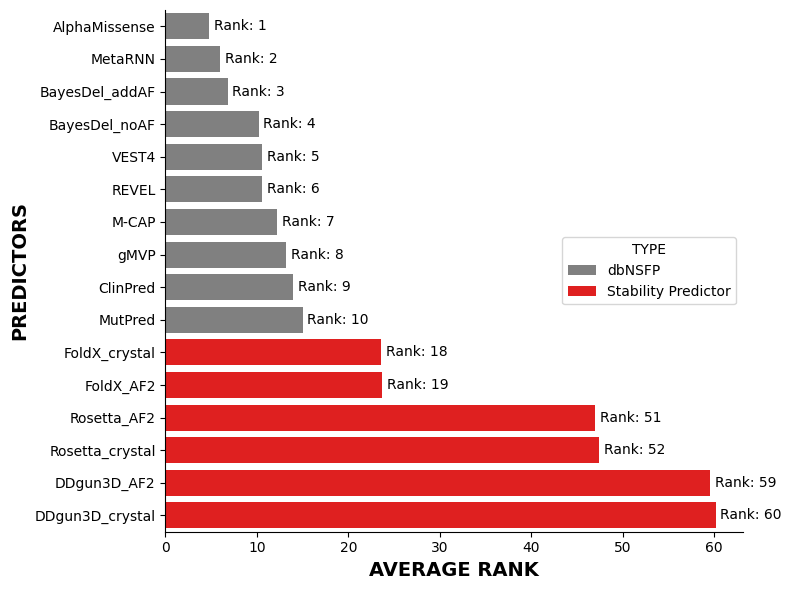

In [15]:
def filter_df_average_rank(df):
    filter_dbnsfp_df = df[df['TYPE'] == 'dbNSFP'].head(10)
    filter_ddg_df = df[df['TYPE'] == 'Stability Predictor']
    final_df = pd.concat([filter_dbnsfp_df, filter_ddg_df], axis=0)
    final_df = final_df.sort_values(by="average_rank", ascending=True)
    final_df = final_df.reset_index(drop=True)
    final_df['name'] = final_df['name'].str.replace('_rankscore', '')
    return final_df



BRCA1_results_df['GENE'] = "BRCA1"
BRCA1_results_df = BRCA1_results_df.reset_index(drop=True)
BRCA1_results_df['RANK'] = BRCA1_results_df.index+1
BRCT_df['GENE'] = "BRCA1"
BRCT_df = BRCT_df.reset_index(drop=True)
BRCT_df['Rank'] = BRCT_df.index + 1
RING_df['GENE'] = "BRCA1"
RING_df = RING_df.reset_index(drop=True)
RING_df['Rank'] = RING_df.index + 1
PALB2_result_df['GENE'] = 'PALB2'
PALB2_result_df = PALB2_result_df.reset_index(drop=True)
PALB2_result_df['Rank'] = PALB2_result_df.index + 1
result_BRCA2_df['GENE'] = 'BRCA2'
result_BRCA2_df = result_BRCA2_df.reset_index(drop=True)
result_BRCA2_df['Rank'] = result_BRCA2_df.index + 1
result_RAD51C_df['GENE'] = 'RAD51C'
result_RAD51C_df = result_RAD51C_df.reset_index(drop=True)
result_RAD51C_df['Rank'] = result_RAD51C_df.index +1
result_missense_df = pd.concat([BRCA1_results_df, PALB2_result_df,RING_df, BRCT_df,
                               result_BRCA2_df, result_RAD51C_df], axis=0)
drop_cols = ['foldetta_crystal', 'LINSIGHT_rankscore']
result_missense_df = result_missense_df[result_missense_df['name'] != "LINSIGHT_rankscore"]
result_missense_df['name'] = result_missense_df['name'].str.replace('_rankscore', '')
result_missense_df = result_missense_df.sort_values(['Rank'], ascending=True)
result_missense_df = result_missense_df.reset_index(drop=True)
result_missense_df['name'] = result_missense_df['name'].str.replace('_3EU7', '').str.replace('_2W18', '').str.replace('_1MJE', '').str.replace('_8FAZ', '').str.replace('_1JNX', '').str.replace('_4OFB', '').str.replace('_7LYB', '')
result_missense_df = result_missense_df.sort_values('Rank', ascending=True).reset_index(drop=True)

# Calculate average rank
result_missense_df['average_rank'] = result_missense_df.groupby('name')['Rank'].transform('mean')
result_missense_df['average_rank'] = result_missense_df['average_rank'].abs()
result_missense_df['average_AUC'] = result_missense_df.groupby('name')['AUC'].transform('mean')
result_missense_df['average_AUC'] = result_missense_df.groupby('name')['AUC'].transform('mean')
result_missense_df['average_AUC_CI_low'] = result_missense_df.groupby('name')['AUC_CI_low'].transform('mean')
result_missense_df['average_AUC_CI_high'] = result_missense_df.groupby('name')['AUC_CI_high'].transform('mean')
result_missense_df['average_AUC'] = result_missense_df['average_AUC'].abs()
#result_missense_df = result_missense_df.sort_values(['average_rank'], ascending=True)
result_missense_df = result_missense_df.sort_values(['average_AUC'], ascending=False)
result_missense_grouped_df = result_missense_df[['name', 'TYPE','average_rank','average_AUC', 'average_AUC_CI_low', 'average_AUC_CI_high']]
result_missense_grouped_df = result_missense_grouped_df.drop_duplicates()
result_missense_grouped_df = result_missense_grouped_df.reset_index(drop=True)
result_missense_grouped_df = result_missense_grouped_df.sort_values(['average_rank'], ascending=True)
result_missense_grouped_df = result_missense_grouped_df.reset_index(drop=True)
result_missense_grouped_df['Rank'] = result_missense_grouped_df.index + 1
result_missense_filter_df = filter_df_average_rank(result_missense_grouped_df)

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red', 'COMB':'yellow'}
plt.figure(figsize=(8, 6))

result_missense_filter_df['name'] = result_missense_filter_df['name'].str.strip()

# Convert names in the bar plot to lowercase
result_missense_filter_df['name_lower'] = result_missense_filter_df['name'].str.lower()

# Create the bar plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=result_missense_filter_df, x='average_rank', y='name', ci=None, hue='TYPE',
                 dodge=False, palette=custom_palette)

# Annotate each bar with its corresponding rank
for p in ax.patches:
    y_value = p.get_y() + p.get_height() / 2
    name = result_missense_filter_df.iloc[int(y_value)]['name']
    rank = result_missense_filter_df.loc[result_missense_filter_df['name'] == name,
                                         'Rank'].values

    if len(rank) > 0:
        ax.annotate(f'Rank: {rank[0]}', (p.get_x() + p.get_width() + 0.5, p.get_y() + p.get_height() / 2),
                    ha='left', va='center')
plt.xlabel('AVERAGE RANK', fontsize=14, fontweight='bold')  # Change xlabel
plt.ylabel('PREDICTORS', fontsize=14, fontweight='bold')  # Change ylabel
#plt.title('AUC  Confidence Intervals')
sns.despine()
plt.tight_layout()
plt.savefig('insilico_predictor_rank.png', dpi=300)
plt.show()

#sns.barplot(data=result_missense_filter_df, x='average_rank', y='name', ci=None, hue='TYPE', 
#            dodge=False, palette=custom_palette) 

#ax = sns.barplot(data=result_missense_filter_df, x='average_rank', y='name', ci=None, hue='TYPE',
#                 dodge=False, palette=custom_palette)
#rank = 0
#for p in ax.patches:
#    print(p)
    #rank = rank +1
    #print(result_missense_filter_df.loc[result_missense_filter_df['name'] =='AlphaMissense', 'Rank'])
#    rank = result_missense_filter_df.loc[result_missense_filter_df['name'] == p.get_y(),'Rank'].values[0]
    #ax.annotate(f'Rank: {rank}', (p.get_x() + p.get_width() + 0.5, p.get_y() + p.get_height() / 2),
    #            ha='left', va='center')
# Flip x and y axes
#plt.errorbar(x=result_missense_filter_df['average_AUC'], y=range(len(result_missense_filter_df)), 
#             xerr=[result_missense_filter_df['average_AUC'] - result_missense_filter_df['average_AUC_CI_low'],
#                   result_missense_filter_df['average_AUC_CI_high'] - result_missense_filter_df['average_AUC']], 
#             fmt='|', color='black', capsize=5)  # Add custom error bars


# Define custom palette
#custom_palette = {'dbNSFP': 'grey', 'DDG': 'red'}
#plt.figure(figsize=(20, 16))
#sns.boxplot(data=result_missense_df, y='name', x='AUC')
#plt.xlabel('Name')
#plt.ylabel('AUC')
#plt.title('Boxplot of AUC for Different Names')
#plt.show()
#plt.figure(figsize=(12, 6))

#BRCT_df
#RING_df 
#PALB2_result_df
#result_RAD51C_df
#result_BRCA2_df
#result_BRCA2_dbd_df
result_missense_filter_df.to_csv("predictor_rank_results.data.csv", index=None)

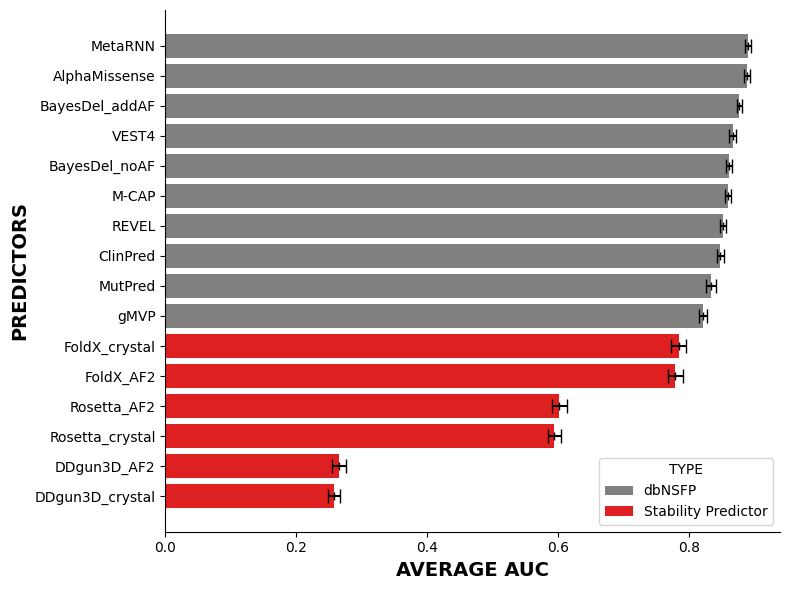

In [16]:
result_missense_filter_auc_df = result_missense_filter_df.sort_values(by="average_AUC", ascending=False)
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=result_missense_filter_auc_df, x='average_AUC', y='name', ci=None, hue='TYPE',
                 dodge=False, palette=custom_palette)
plt.errorbar(x=result_missense_filter_auc_df['average_AUC'], y=range(len(result_missense_filter_auc_df)), 
             xerr=[result_missense_filter_auc_df['average_AUC'] - result_missense_filter_auc_df['average_AUC_CI_low'],
                   result_missense_filter_auc_df['average_AUC_CI_high'] - result_missense_filter_auc_df['average_AUC']], 
             fmt='|', color='black', capsize=5)  # Add custom error bars

plt.xlabel('AVERAGE AUC', fontsize=14, fontweight='bold')  # Change xlabel
plt.ylabel('PREDICTORS', fontsize=14, fontweight='bold')  # Change ylabel
#plt.title('AUC  Confidence Intervals')
sns.despine()
plt.tight_layout()
plt.savefig('insilico_predictor_AUC.png', dpi=300)
plt.show()

In [17]:
result_missense_filter_df

,name,TYPE,average_rank,average_AUC,average_AUC_CI_low,average_AUC_CI_high,Rank,name_lower
0,AlphaMissense,dbNSFP,4.800000,0.888228,0.883521,0.892935,1,alphamissense
1,MetaRNN,dbNSFP,6.000000,0.889798,0.885667,0.893930,2,metarnn
2,BayesDel_addAF,dbNSFP,6.800000,0.876629,0.872336,0.880921,3,bayesdel_addaf
3,BayesDel_noAF,dbNSFP,10.200000,0.861258,0.856460,0.866056,4,bayesdel_noaf
4,VEST4,dbNSFP,10.600000,0.866274,0.861442,0.871107,5,vest4
5,REVEL,dbNSFP,10.600000,0.851990,0.847352,0.856628,6,revel
6,M-CAP,dbNSFP,12.200000,0.859359,0.854217,0.864501,7,m-cap
7,gMVP,dbNSFP,13.200000,0.820654,0.814793,0.826515,8,gmvp
8,ClinPred,dbNSFP,14.000000,0.847652,0.842892,0.852413,9,clinpred
9,MutPred,dbNSFP,15.000000,0.833558,0.825579,0.841536,10,mutpred


In [18]:


BRCA1_results_filter_df = filter_df_AUC(BRCA1_results_df)
BRCA2_results_filter_df = filter_df_AUC(result_BRCA2_df)
RAD51C_results_filter_df = filter_df_AUC(result_RAD51C_df)
PALB2_results_filter_df = filter_df_AUC(PALB2_result_df)
#result_RAD51C_df 
#PALB2_result_df
#result_BRCA2_df
PALB2_results_filter_df

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,TYPE,GENE,Rank
0,MetaRNN,0.901806,0.892322,0.911290,0.764219,0.743755,0.784682,dbNSFP,PALB2,1
1,MutationTaster_converted,0.878271,0.867584,0.888958,0.623791,0.599937,0.647645,dbNSFP,PALB2,2
2,M-CAP,0.858505,0.845526,0.871483,0.750588,0.728847,0.772329,dbNSFP,PALB2,3
3,EVE,0.843254,0.822160,0.864347,0.388623,0.345967,0.431280,dbNSFP,PALB2,4
4,MPC,0.831833,0.816207,0.847459,0.454126,0.421844,0.486407,dbNSFP,PALB2,5
5,BayesDel_addAF,0.820363,0.810656,0.830069,0.576604,0.555915,0.597293,dbNSFP,PALB2,6
6,phyloP470way_mammalian,0.810189,0.799763,0.820616,0.399661,0.377225,0.422097,dbNSFP,PALB2,7
7,MutPred,0.804654,0.783124,0.826184,0.691090,0.664965,0.717215,dbNSFP,PALB2,8
8,ClinPred,0.792191,0.780676,0.803705,0.404540,0.381099,0.427981,dbNSFP,PALB2,9
9,DEOGEN2,0.789325,0.778264,0.800386,0.423312,0.402391,0.444234,dbNSFP,PALB2,10


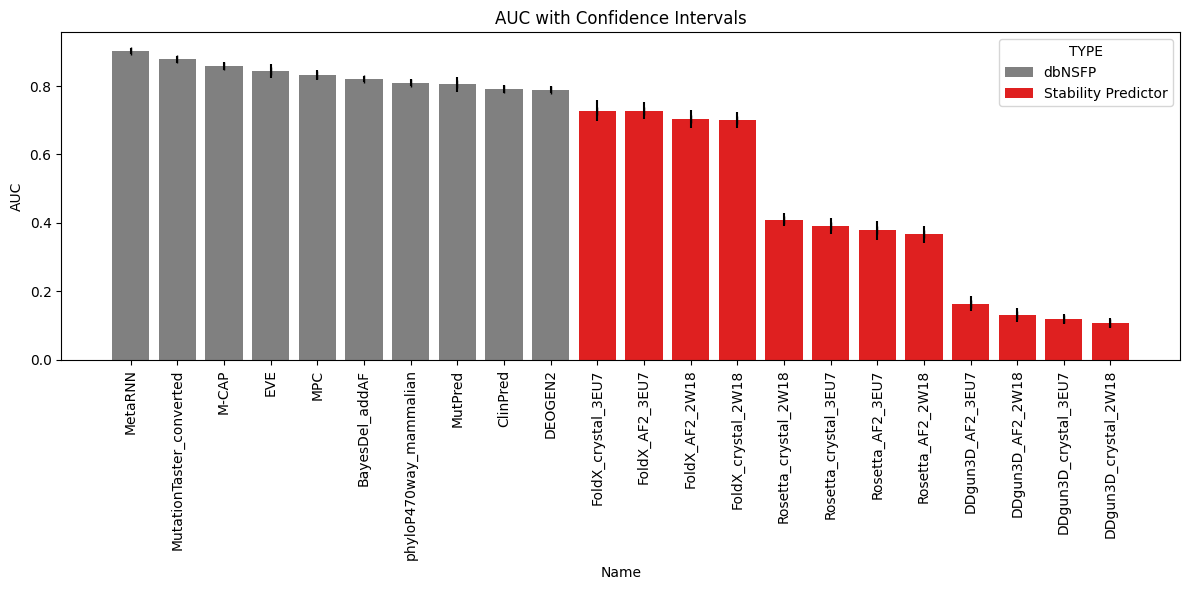

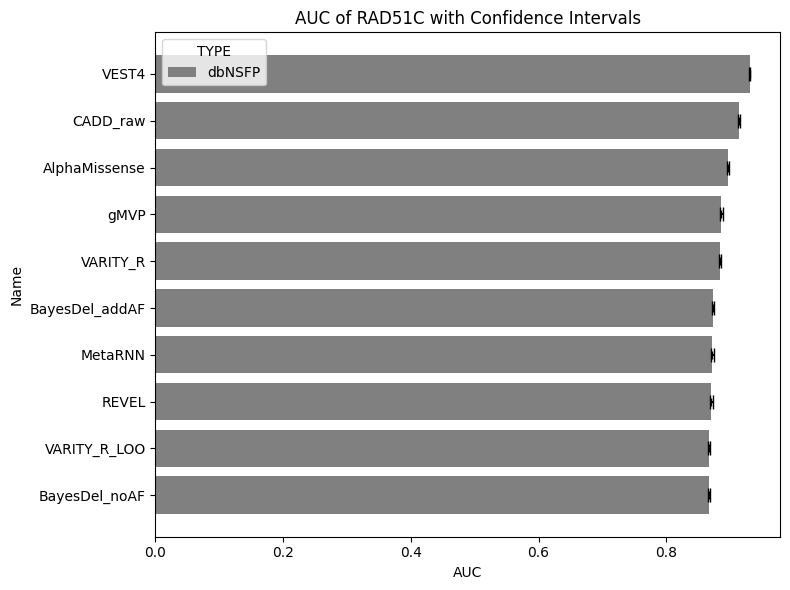

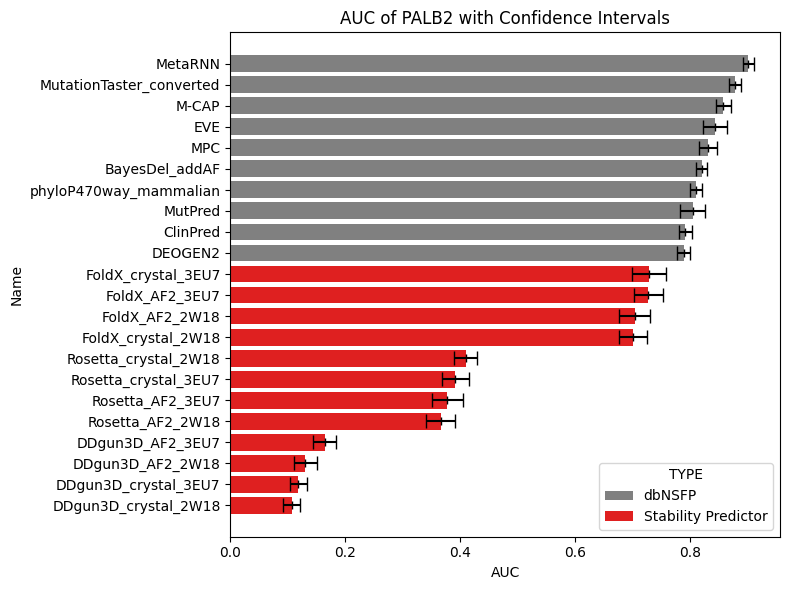

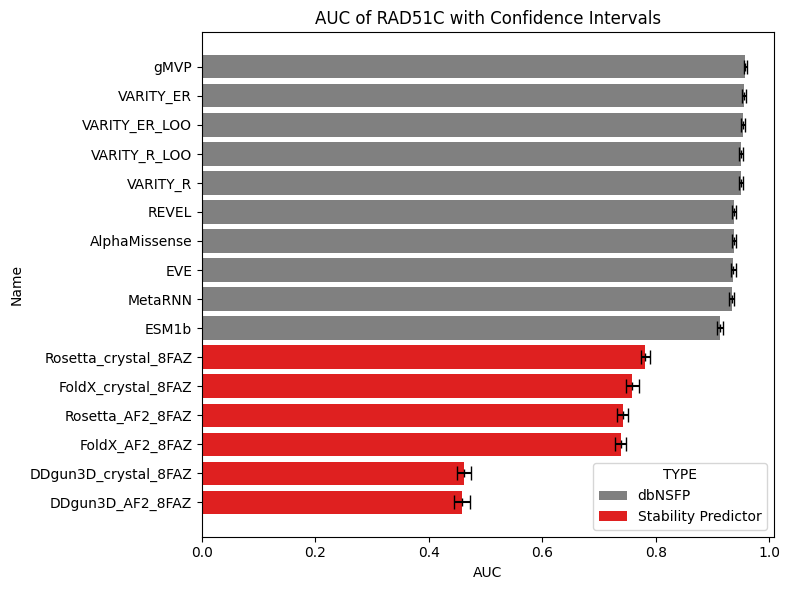

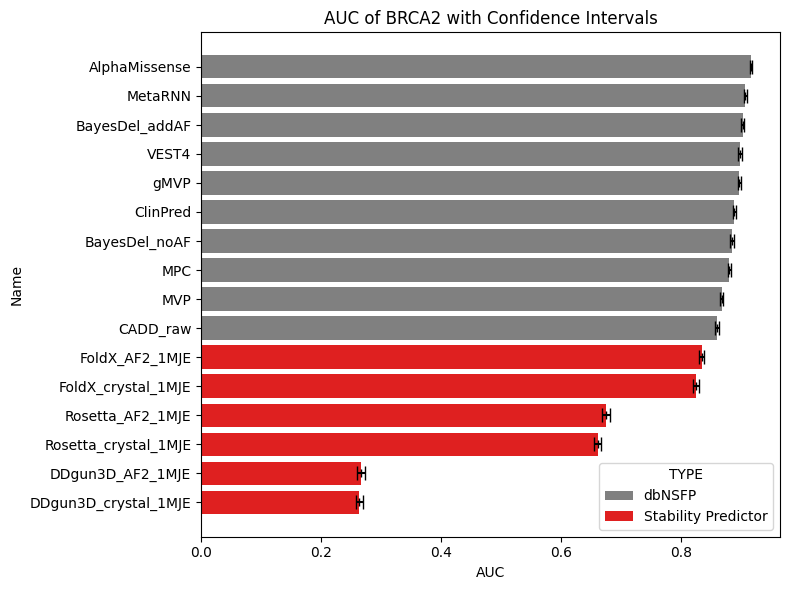

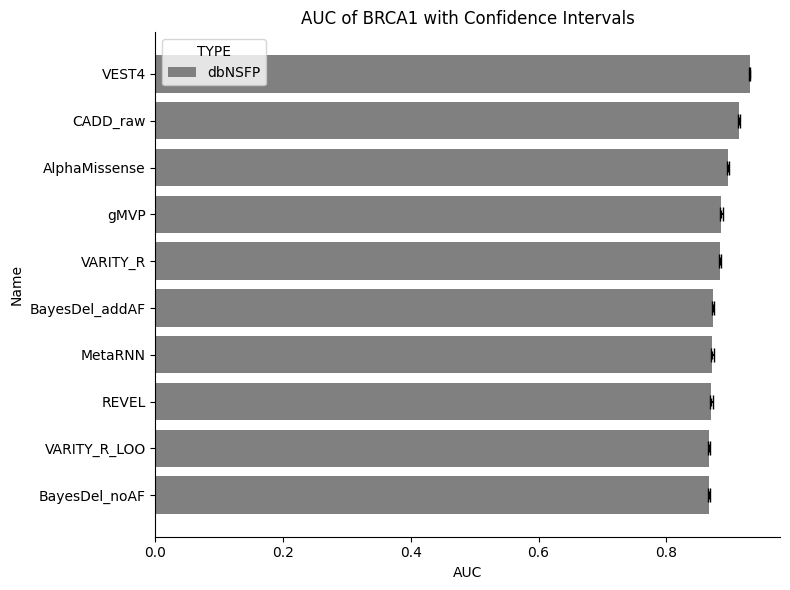

In [19]:
custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(12, 6))
sns.barplot(data=PALB2_results_filter_df, x='name', y='AUC', ci=None,hue='TYPE', dodge=False, palette=custom_palette)  # Plot bars without error bars
plt.errorbar(x=PALB2_results_filter_df.index, y=PALB2_results_filter_df['AUC'], 
             yerr=[PALB2_results_filter_df['AUC'] - PALB2_results_filter_df['AUC_CI_low'],
                   PALB2_results_filter_df['AUC_CI_high'] - PALB2_results_filter_df['AUC']], fmt='|', color='black')  # Add custom error bars
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Name')
plt.ylabel('AUC')
plt.title('AUC with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=BRCA1_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', dodge=False, palette=custom_palette)  # Flip x and y axes
plt.errorbar(x=BRCA1_results_filter_df['AUC'], y=range(len(BRCA1_results_filter_df)), 
             xerr=[BRCA1_results_filter_df['AUC'] - BRCA1_results_filter_df['AUC_CI_low'],
                   BRCA1_results_filter_df['AUC_CI_high'] - BRCA1_results_filter_df['AUC']], 
             fmt='|', color='black', capsize=5)  # Add custom error bars
plt.xlabel('AUC')  # Change xlabel
plt.ylabel('Name')  # Change ylabel
plt.title('AUC of RAD51C with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=PALB2_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', dodge=False, palette=custom_palette)  # Flip x and y axes
plt.errorbar(x=PALB2_results_filter_df['AUC'], y=range(len(PALB2_results_filter_df)), 
             xerr=[PALB2_results_filter_df['AUC'] - PALB2_results_filter_df['AUC_CI_low'],
                   PALB2_results_filter_df['AUC_CI_high'] - PALB2_results_filter_df['AUC']], 
             fmt='|', color='black', capsize=5)  # Add custom error bars
plt.xlabel('AUC')  # Change xlabel
plt.ylabel('Name')  # Change ylabel
plt.title('AUC of PALB2 with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=RAD51C_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', dodge=False, palette=custom_palette)  # Flip x and y axes
plt.errorbar(x=RAD51C_results_filter_df['AUC'], y=range(len(RAD51C_results_filter_df)), 
             xerr=[RAD51C_results_filter_df['AUC'] - RAD51C_results_filter_df['AUC_CI_low'],
                   RAD51C_results_filter_df['AUC_CI_high'] - RAD51C_results_filter_df['AUC']], 
             fmt='|', color='black', capsize=5)  # Add custom error bars
plt.xlabel('AUC')  # Change xlabel
plt.ylabel('Name')  # Change ylabel
plt.title('AUC of RAD51C with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=BRCA2_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', 
            dodge=False, palette=custom_palette)  # Flip x and y axes
plt.errorbar(x=BRCA2_results_filter_df['AUC'], y=range(len(BRCA2_results_filter_df)), 
             xerr=[BRCA2_results_filter_df['AUC'] - BRCA2_results_filter_df['AUC_CI_low'],
                   BRCA2_results_filter_df['AUC_CI_high'] - BRCA2_results_filter_df['AUC']],
             fmt='|', color='black', capsize=5)  # Add custom error bars
plt.xlabel('AUC')  # Change xlabel
plt.ylabel('Name')  # Change ylabel
plt.title('AUC of BRCA2 with Confidence Intervals')
plt.tight_layout()
plt.show()

custom_palette = {'dbNSFP': 'grey', 'Stability Predictor': 'red'}
plt.figure(figsize=(8, 6))
sns.barplot(data=BRCA1_results_filter_df, x='AUC', y='name', ci=None, hue='TYPE', 
            dodge=False, palette=custom_palette)  # Flip x and y axes
plt.errorbar(x=BRCA1_results_filter_df['AUC'], y=range(len(BRCA1_results_filter_df)), 
             xerr=[BRCA1_results_filter_df['AUC'] - BRCA1_results_filter_df['AUC_CI_low'],
                   BRCA1_results_filter_df['AUC_CI_high'] - BRCA1_results_filter_df['AUC']], 
             fmt='|', color='black', capsize=5)  # Add custom error bars
plt.xlabel('AUC')  # Change xlabel
plt.ylabel('Name')  # Change ylabel
plt.title('AUC of BRCA1 with Confidence Intervals')
sns.despine()
plt.tight_layout()
plt.show()

In [20]:
RAD51C_dbnsfp_df = pd.read_csv(RAD51C_dbnsfp_data)
PALB2_dbnsfp_df = pd.read_csv(PALB2_dbnsfp_data)
BRCA1_dbnsfp_df = pd.read_csv(BRCA1_dbnsfp_data)
BRCA2_dbnsfp_df = pd.read_csv(BRCA2_dbnsfp_data)

RAD51C_count_df = pd.DataFrame(RAD51C_dbnsfp_df['clinvar_clnsig'].value_counts()).reset_index()
PALB2_count_df = pd.DataFrame(PALB2_dbnsfp_df['clinvar_clnsig'].value_counts()).reset_index()
BRCA1_count_df = pd.DataFrame(BRCA1_dbnsfp_df['clinvar_clnsig'].value_counts()).reset_index()
BRCA2_count_df = pd.DataFrame(BRCA2_dbnsfp_df['clinvar_clnsig'].value_counts()).reset_index()

def get_percetange(df):
    filtered_df = df[df['index'].isin(['unknown', 'Uncertain_significance', 
                                       'no_classification_for_the_single_variant', 'Conflicting_classifications_of_pathogenicity'])]
    total_count = df['clinvar_clnsig'].sum()
    filtered_count = filtered_df['clinvar_clnsig'].sum()
    per = filtered_count/total_count
    print(per)
    #filtered_df['percentage'] = (filtered_df['clinvar_clnsig'] / total_count) * 100
    #print(filtered_df)
get_percetange(PALB2_count_df)
get_percetange(RAD51C_count_df)

0.9637759385870217
0.9769762087490407


In [21]:
BRCT_ddg_df = BRCT_df[(BRCT_df['TYPE'] == 'Stability Predictor') & (~BRCT_df['AUC'].isna())]
RING_ddg_df = RING_df[(RING_df['TYPE'] == 'Stability Predictor') & (~RING_df['AUC'].isna())]
BRCA2_results_filter_ddg_df = BRCA2_results_filter_df[BRCA2_results_filter_df['TYPE'] == 'Stability Predictor']
RAD51C_results_filter_ddg_df = RAD51C_results_filter_df[RAD51C_results_filter_df['TYPE']== 'Stability Predictor']
PALB2_results_filter_ddg_df  =PALB2_results_filter_df[PALB2_results_filter_df['TYPE']=='Stability Predictor']

ddg_af2_crystal_df = pd.concat([PALB2_results_filter_ddg_df, RAD51C_results_filter_ddg_df,
                                BRCA2_results_filter_ddg_df, RING_ddg_df, BRCT_ddg_df], axis=0)


ddg_af2_crystal_df[['PREDICTOR', 'MODEL', 'PDB']] = ddg_af2_crystal_df['name'].str.split('_',expand=True)
ddg_af2_crystal_df['PDB_PREDICTOR'] = ddg_af2_crystal_df['PREDICTOR'] +  "_" + ddg_af2_crystal_df['PDB']


ddg_af2_crystal_df['ERROR'] = (ddg_af2_crystal_df['AUC_CI_high'] - ddg_af2_crystal_df['AUC_CI_low']) / 2
ddg_af2_crystal_df[(ddg_af2_crystal_df['GENE'] == 'RAD51C') & 
                   (ddg_af2_crystal_df['MODEL'] == 'AF2') &
                  (ddg_af2_crystal_df['PDB'] == '8FAZ')]


ddg_af2_crystal_df.to_csv("results_AUC_all_results_categorical.csv", index=None)


/research/bsi/projects/PI/tertiary/Couch_Fergus_coucf/s123456.general_utility/python_virtual/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 800x600 with 0 Axes>

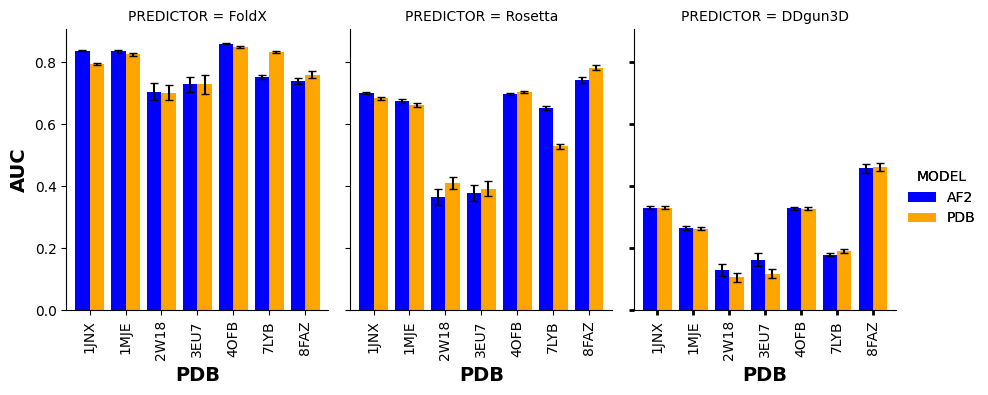

In [22]:
def errplot(x, y, yerr, hue, **kwargs):
    data = kwargs.pop('data')
    p = data.pivot_table(index=x, columns=hue, values=y, aggfunc='mean')
    err = data.pivot_table(index=x, columns=hue, values=yerr, aggfunc='mean')
    p.plot(kind='bar', yerr=err, ax=plt.gca(), **kwargs, capsize=3)
ddg_af2_crystal_df['label'] = ddg_af2_crystal_df['MODEL'].apply(lambda x: "PDB" if x == 'crystal' else x)

plt.figure(figsize=(8, 6))
g = sns.FacetGrid(ddg_af2_crystal_df, col="PREDICTOR", size=4, aspect=.7,  ) 
g.map_dataframe(errplot, "PDB", "AUC", 'ERROR', "label",  color=['blue', 'orange'], width=0.8)
g.add_legend(title="MODEL")
plt.tick_params(axis='x', width=2)  # Increase thickness of x ticks
plt.tick_params(axis='y', width=2)

g.set_ylabels('AUC', fontsize=14, fontweight='bold')
g.set_xlabels('PDB', fontsize=14, fontweight='bold')
g.add_legend(title="MODEL")
#plt.savefig('correlation_mave_results.png', dpi=300)
#plt.title('Boxplot of Mean Distance by PDB')
plt.savefig('auc_stability_results.png', dpi=300)
plt.show()

#plt.show()


In [23]:
ddg_af2_crystal_df

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,TYPE,GENE,Rank,PREDICTOR,MODEL,PDB,PDB_PREDICTOR,ERROR,label
10,FoldX_crystal_3EU7,0.728378,0.698426,0.758330,0.408517,0.376710,0.440323,Stability Predictor,PALB2,18,FoldX,crystal,3EU7,FoldX_3EU7,0.029952,PDB
11,FoldX_AF2_3EU7,0.727786,0.702330,0.753242,0.353227,0.322754,0.383701,Stability Predictor,PALB2,19,FoldX,AF2,3EU7,FoldX_3EU7,0.025456,AF2
12,FoldX_AF2_2W18,0.703634,0.676375,0.730893,0.274853,0.249803,0.299904,Stability Predictor,PALB2,24,FoldX,AF2,2W18,FoldX_2W18,0.027259,AF2
13,FoldX_crystal_2W18,0.700875,0.677203,0.724547,0.241364,0.223008,0.259720,Stability Predictor,PALB2,25,FoldX,crystal,2W18,FoldX_2W18,0.023672,PDB
14,Rosetta_crystal_2W18,0.409567,0.389609,0.429524,0.119081,0.110399,0.127763,Stability Predictor,PALB2,56,Rosetta,crystal,2W18,Rosetta_2W18,0.019957,PDB
15,Rosetta_crystal_3EU7,0.391646,0.368009,0.415283,0.110030,0.101561,0.118498,Stability Predictor,PALB2,58,Rosetta,crystal,3EU7,Rosetta_3EU7,0.023637,PDB
16,Rosetta_AF2_3EU7,0.377832,0.351154,0.404510,0.114573,0.105158,0.123988,Stability Predictor,PALB2,59,Rosetta,AF2,3EU7,Rosetta_3EU7,0.026678,AF2
17,Rosetta_AF2_2W18,0.366164,0.340768,0.391560,0.115218,0.104985,0.125451,Stability Predictor,PALB2,60,Rosetta,AF2,2W18,Rosetta_2W18,0.025396,AF2
18,DDgun3D_AF2_3EU7,0.164009,0.143198,0.184820,0.081952,0.075933,0.087971,Stability Predictor,PALB2,64,DDgun3D,AF2,3EU7,DDgun3D_3EU7,0.020811,AF2
19,DDgun3D_AF2_2W18,0.130660,0.110540,0.150781,0.081554,0.075689,0.087419,Stability Predictor,PALB2,66,DDgun3D,AF2,2W18,DDgun3D_2W18,0.020121,AF2


In [24]:
RAD51C_results_filter_ddg_df

,name,AUC,AUC_CI_low,AUC_CI_high,PI_AUC,PR_AUC_low,PR_AUC_high,TYPE,GENE,Rank
10,Rosetta_crystal_8FAZ,0.781558,0.772975,0.790140,0.590945,0.575457,0.606433,Stability Predictor,RAD51C,33
11,FoldX_crystal_8FAZ,0.758480,0.747008,0.769952,0.670641,0.656907,0.684374,Stability Predictor,RAD51C,36
12,Rosetta_AF2_8FAZ,0.741219,0.732264,0.750174,0.523264,0.506834,0.539695,Stability Predictor,RAD51C,37
13,FoldX_AF2_8FAZ,0.737670,0.727824,0.747516,0.586382,0.571642,0.601122,Stability Predictor,RAD51C,39
14,DDgun3D_crystal_8FAZ,0.462061,0.450063,0.474058,0.285019,0.272329,0.297709,Stability Predictor,RAD51C,57
15,DDgun3D_AF2_8FAZ,0.458053,0.443649,0.472457,0.303199,0.289646,0.316752,Stability Predictor,RAD51C,58
